In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Input
from sklearn.utils.class_weight import compute_class_weight

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Load Dataset
print("Loading dataset...")
data = pd.read_csv('/content/traincleaned_data.csv')

Loading dataset...


In [3]:
# EDA and Feature Selection
print("Performing EDA and feature selection...")
important_features = ['ICULOS', 'Age', 'HospAdmTime', 'Temp', 'SBP', 'HR', 'Resp', 'O2Sat']
target = 'SepsisLabel'

Performing EDA and feature selection...


In [4]:
# Handle missing values using KNN Imputer
print("Handling missing values...")
imputer = KNNImputer()
data[important_features] = imputer.fit_transform(data[important_features])

Handling missing values...


In [5]:
# Checking the distribution of data points between the two classes
majority_class = data[data[target] == 0]
minority_class = data[data[target] == 1]
print(f'Number of SepsisLabel 1: {len(minority_class)}')
print(f'Number of SepsisLabel 0: {len(majority_class)}')

Number of SepsisLabel 1: 8304
Number of SepsisLabel 0: 857061


In [6]:
# Undersampling
majority_class_subset = majority_class.sample(n=2*len(minority_class))
data = pd.concat([majority_class_subset, minority_class])


In [7]:
# Data Transformation Function
def get_data_ready(df):
    # Gaussian transformation and standard normalization for important features
    columns_normalized = ['ICULOS', 'Age', 'HospAdmTime', 'Temp', 'SBP', 'HR', 'Resp', 'O2Sat']
    for col in columns_normalized:
        df[col] = np.log(df[col] + 1)  # Gaussian transformation

    # Normalizing using StandardScaler
    scaler = StandardScaler()
    df[columns_normalized] = scaler.fit_transform(df[columns_normalized])

    return df

In [8]:
# Split into train and test datasets
y = data[target]
X = data[important_features]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
# Balance the training data using SMOTE
print("Balancing the dataset...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

Balancing the dataset...


In [21]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "LSTM": Sequential([
        Input(shape=(X_train_balanced.shape[1], 1)),
        LSTM(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    "Conv1D": Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train_balanced.shape[1], 1)),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    "TCN": Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_balanced.shape[1], 1)),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
print("Training and evaluating models...")
results = []
for name, model in models.items():
    if name in ["LSTM", "Conv1D", "TCN"]:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        # Convert the DataFrame to a NumPy array before reshaping
        model.fit(X_train_balanced.values.reshape(-1, X_train_balanced.shape[1], 1), y_train_balanced, epochs=10, batch_size=32, verbose=0)
        # Convert the DataFrame to a NumPy array before reshaping
        y_val_pred_prob = model.predict(X_val.values.reshape(-1, X_val.shape[1], 1)).ravel()
        y_val_pred = (y_val_pred_prob > 0.5).astype(int)
    else:
        model.fit(X_train_balanced, y_train_balanced)
        y_val_pred = model.predict(X_val)
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]

    # Classification Report
    report = classification_report(y_val, y_val_pred, output_dict=True)
    roc_auc = roc_auc_score(y_val, y_val_pred_prob)

    # Append results
    results.append([name, report["accuracy"], report["1"]["precision"], report["1"]["recall"],
                    report["1"]["f1-score"], roc_auc])

Training and evaluating models...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 11638, number of negative: 11638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2011
[LightGBM] [Info] Number of data points in the train set: 23276, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [23]:
# Display results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  Logistic Regression  0.596200   0.413177  0.546862  0.470712  0.621463
1        Random Forest  0.801177   0.697068  0.697637  0.697352  0.854165
2              XGBoost  0.765320   0.658514  0.592502  0.623767  0.821147
3             LightGBM  0.733744   0.610266  0.523227  0.563405  0.771512
4                 LSTM  0.633128   0.460352  0.681337  0.549458  0.706450
5               Conv1D  0.690126   0.548523  0.317848  0.402477  0.669659
6                  TCN  0.604496   0.433773  0.669927  0.526586  0.677150


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      2460
           1       0.43      0.58      0.49      1277

    accuracy                           0.59      3737
   macro avg       0.58      0.59      0.58      3737
weighted avg       0.63      0.59      0.60      3737

--------------------------------------------------


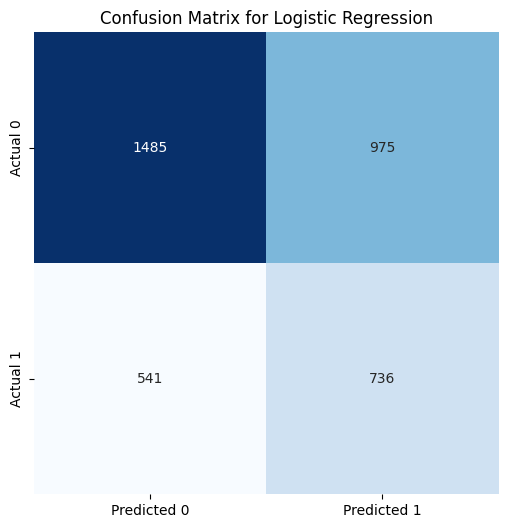

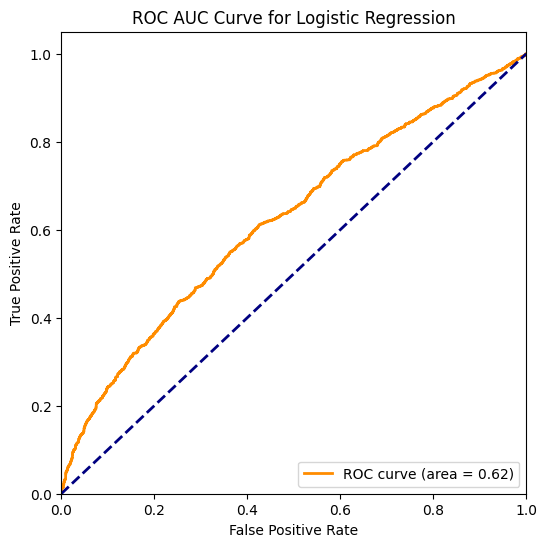

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2460
           1       0.72      0.71      0.72      1277

    accuracy                           0.81      3737
   macro avg       0.79      0.78      0.79      3737
weighted avg       0.81      0.81      0.81      3737

--------------------------------------------------


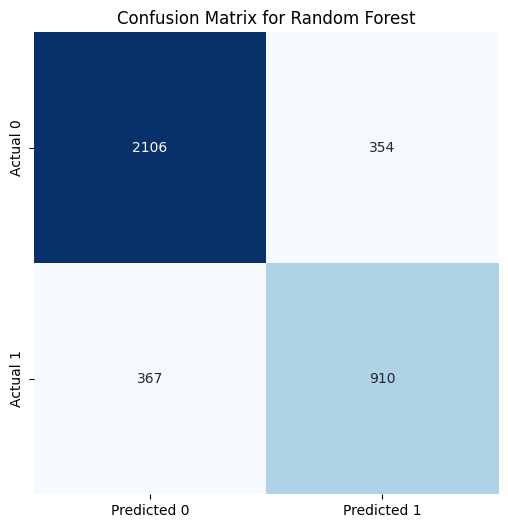

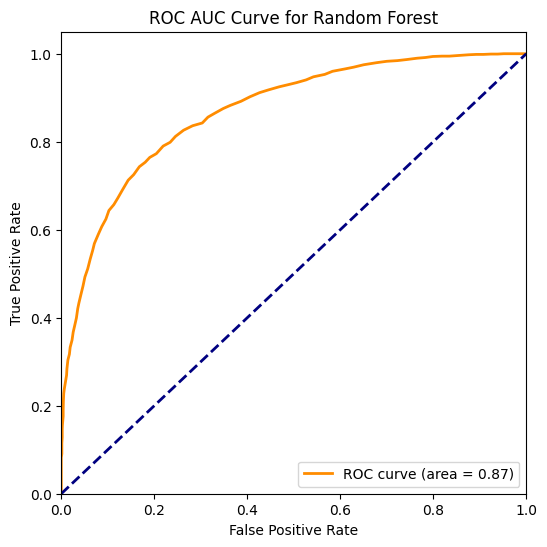

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2460
           1       0.68      0.61      0.65      1277

    accuracy                           0.77      3737
   macro avg       0.75      0.73      0.74      3737
weighted avg       0.77      0.77      0.77      3737

--------------------------------------------------


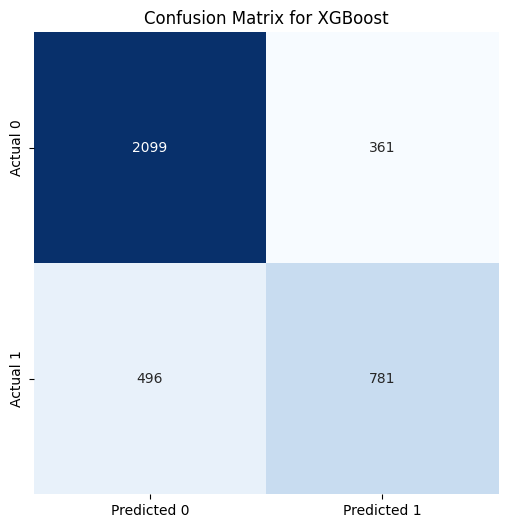

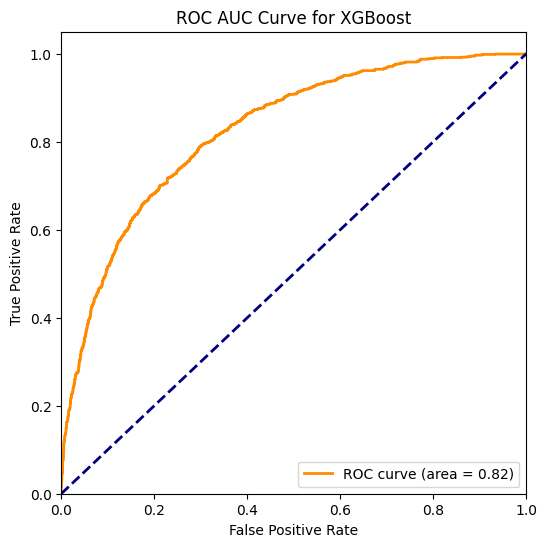

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      2460
           1       0.65      0.53      0.59      1277

    accuracy                           0.74      3737
   macro avg       0.71      0.69      0.70      3737
weighted avg       0.73      0.74      0.73      3737

--------------------------------------------------


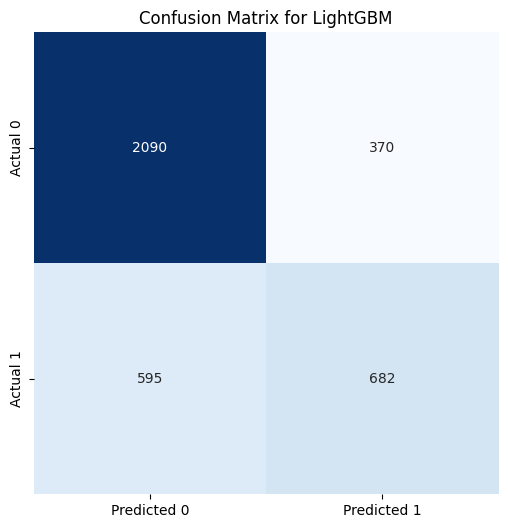

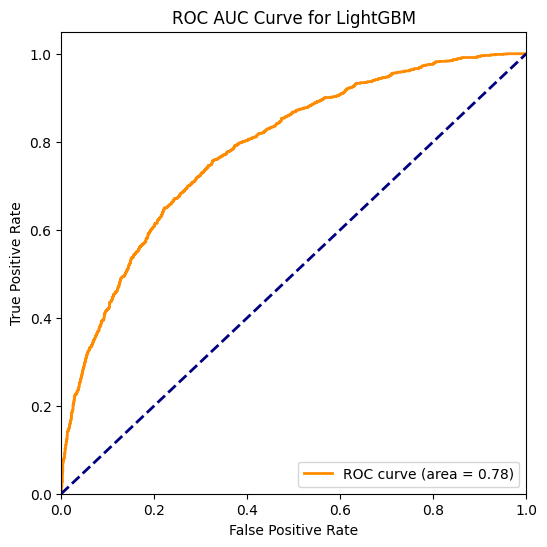

Classification Report for LSTM:
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.59      0.67      2460
           1       0.47      0.69      0.56      1277

    accuracy                           0.63      3737
   macro avg       0.63      0.64      0.62      3737
weighted avg       0.68      0.63      0.63      3737

--------------------------------------------------


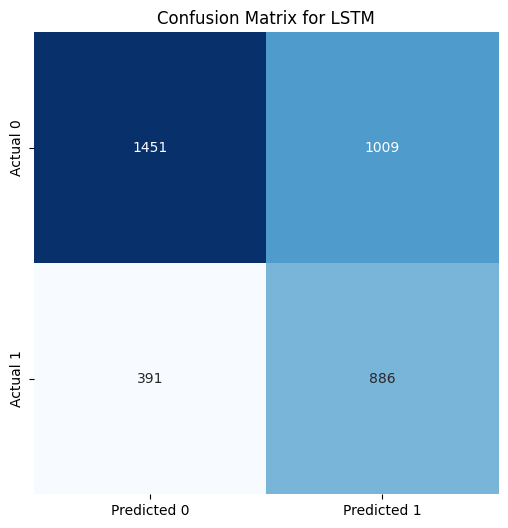

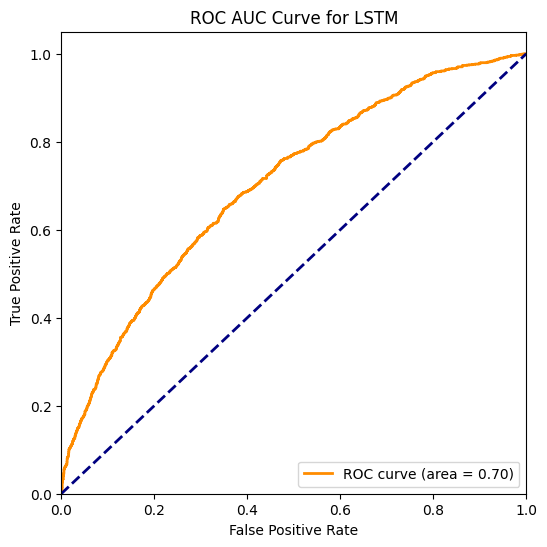

Classification Report for Conv1D:
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      2460
           1       0.53      0.31      0.39      1277

    accuracy                           0.67      3737
   macro avg       0.62      0.58      0.58      3737
weighted avg       0.64      0.67      0.64      3737

--------------------------------------------------


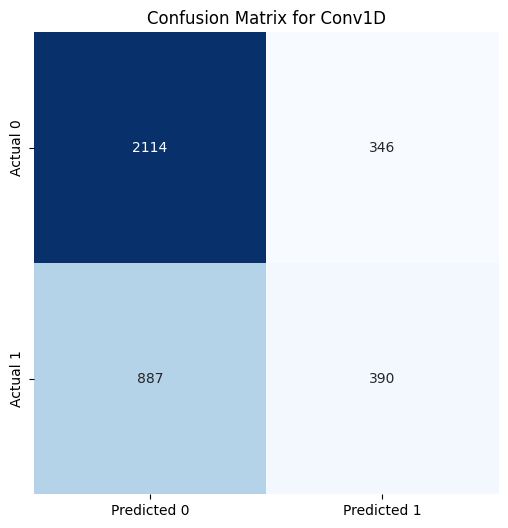

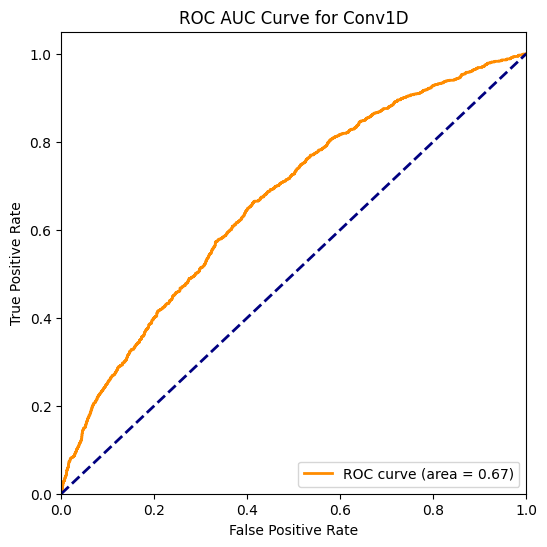

Classification Report for TCN:
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.57      0.66      2460
           1       0.45      0.68      0.54      1277

    accuracy                           0.61      3737
   macro avg       0.61      0.63      0.60      3737
weighted avg       0.67      0.61      0.62      3737

--------------------------------------------------


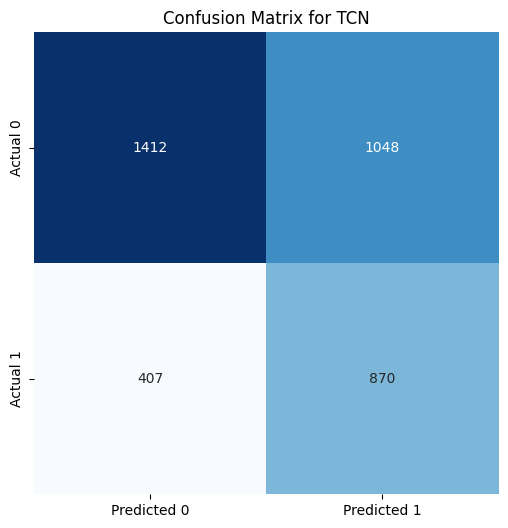

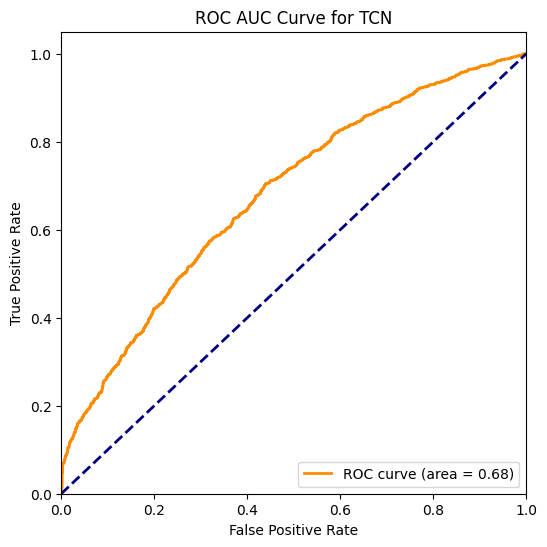

In [24]:
# prompt: display classification report , roc auc curve graph and confusion matrix for each model. "Display the classification report for each model
# for model_name in results_df['Model']:
#   print(f"Classification Report for {model_name}:")
#   if model_name in ["LSTM", "Conv1D", "TCN"]:
#       # For the LSTM, Conv1D, and TCN models, you'll need to predict on the test set again
#       if model_name == "LSTM":
#           y_pred_prob = models[model_name].predict(X_test.values.reshape(-1, X_test.shape[1], 1)).ravel()
#       elif model_name == "Conv1D":
#           y_pred_prob = models[model_name].predict(X_test.values.reshape(-1, X_test.shape[1], 1)).ravel()
#       elif model_name == "TCN":
#           y_pred_prob = models[model_name].predict(X_test.values.reshape(-1, X_test.shape[1], 1)).ravel()
#       y_pred = (y_pred_prob > 0.5).astype(int)
#   else:
#     y_pred = models[model_name].predict(X_test)
#     y_pred_prob = models[model_name].predict_proba(X_test)[:, 1]
#   print(classification_report(y_test, y_pred))
#   print("-" * 50)"

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

for model_name in results_df['Model']:
  print(f"Classification Report for {model_name}:")
  if model_name in ["LSTM", "Conv1D", "TCN"]:
      if model_name == "LSTM":
          y_pred_prob = models[model_name].predict(X_test.values.reshape(-1, X_test.shape[1], 1)).ravel()
      elif model_name == "Conv1D":
          y_pred_prob = models[model_name].predict(X_test.values.reshape(-1, X_test.shape[1], 1)).ravel()
      elif model_name == "TCN":
          y_pred_prob = models[model_name].predict(X_test.values.reshape(-1, X_test.shape[1], 1)).ravel()
      y_pred = (y_pred_prob > 0.5).astype(int)
  else:
    y_pred = models[model_name].predict(X_test)
    y_pred_prob = models[model_name].predict_proba(X_test)[:, 1]
  print(classification_report(y_test, y_pred))
  print("-" * 50)

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=["Predicted 0", "Predicted 1"],
              yticklabels=["Actual 0", "Actual 1"])
  plt.title(f"Confusion Matrix for {model_name}")
  plt.show()

  # ROC AUC Curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC AUC Curve for {model_name}')
  plt.legend(loc="lower right")
  plt.show()

In [25]:
from sklearn.ensemble import VotingClassifier

# Assuming 'models' dictionary from your previous code still exists
# Create a voting classifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('xgb', models['XGBoost'])
], voting='soft')  # 'soft' voting considers predicted probabilities

# Train the ensemble model
ensemble_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = ensemble_model.predict(X_test)
y_pred_prob = ensemble_model.predict_proba(X_test)[:, 1]

# Evaluate the ensemble model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:39:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2460
           1       0.72      0.68      0.70      1277

    accuracy                           0.80      3737
   macro avg       0.78      0.77      0.77      3737
weighted avg       0.80      0.80      0.80      3737

ROC AUC Score: 0.8607655136848941


In [29]:
# prompt: best model is "ensemble model". modify the code "pbest_model = models["Random Forest"]
# joblib.dump(best_model, 'best_model.pkl')
# print("Model saved as 'best_model.pkl'")"

best_model = ensemble_model
joblib.dump(best_model, 'best_model.pkl')
print("Model saved as 'best_model.pkl'")

Model saved as 'best_model.pkl'


In [30]:
"""pbest_model = models["Random Forest"]
joblib.dump(best_model, 'best_model.pkl')
print("Model saved as 'best_model.pkl'")"""

'pbest_model = models["Random Forest"]\njoblib.dump(best_model, \'best_model.pkl\')\nprint("Model saved as \'best_model.pkl\'")'

In [ ]:
# Model Interpretation with SHAP
print("Generating SHAP summary plot...")
# Use KernelExplainer instead of TreeExplainer
explainer = shap.KernelExplainer(best_model.predict_proba, X_val)  # Use predict_proba for classification
shap_values = explainer.shap_values(X_val)

# Access SHAP values for the positive class (class 1)
shap_values_class1 = shap_values[1] # This now correctly selects values for class 1

shap.summary_plot(shap_values_class1, X_val, plot_type="bar")
"""# Model Interpretation with SHAP
print("Generating SHAP summary plot...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)

# Select the SHAP values for the positive class (class 1) for all samples
# shap_values_class1 = shap_values[1]  # Incorrect: This selects only the second sample
shap_values_class1 = shap_values[:, :, 1] # Correct: This selects SHAP values for class 1 for all samples


shap.summary_plot(shap_values_class1, X_val, plot_type="bar")"""

Generating SHAP summary plot...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/3737 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][:, 1], X_val.iloc[0,:])


In [ ]:
# Dependence Plot
shap.dependence_plot("Age", shap_values[:, :, 1], X_val)


In [ ]:
# Decision Plot
shap.decision_plot(explainer.expected_value[1], shap_values[1][:, 1], X_val.iloc[[1]], feature_names=important_features)

In [ ]:
# Deployment Example
def predict(input_data):
    model = joblib.load('best_model.pkl')
    input_data_scaled = scaler.transform([input_data])
    prediction = model.predict(input_data_scaled)
    probability = model.predict_proba(input_data_scaled)[0][1]
    return prediction[0], probability

In [ ]:
# Deployment Example
def predict(input_data):
    model = joblib.load('best_model.pkl')

    # Define scaler here as it wasn't defined globally
    scaler = StandardScaler()
    # You need to fit the scaler on the same data you used for training.
    # Assuming you have a DataFrame 'X' with your training data:
    # You probably want to store this scaler as well as the model if using in production.
    scaler.fit(X[important_features])

    input_data_scaled = scaler.transform([input_data])
    prediction = model.predict(input_data_scaled)
    probability = model.predict_proba(input_data_scaled)[0][1]
    return prediction[0], probability


In [ ]:
# Example prediction
example_input = [10, 45, -3.2, 36.5, 120, 85, 20, 98]
pred, prob = predict(example_input)
print(f"Prediction: {pred}, Probability: {prob:.2f}")

In [ ]:
import gradio as gr

def predict_for_ui(ICULOS, Age, HospAdmTime, Temp, SBP, HR, Resp, O2Sat):
    input_data = [ICULOS, Age, HospAdmTime, Temp, SBP, HR, Resp, O2Sat]
    pred, prob = predict(input_data)
    return f"Prediction: {pred}", f"Probability: {prob:.2f}"

iface = gr.Interface(
    fn=predict_for_ui,
    inputs=[
        gr.Number(label="ICULOS"),
        gr.Number(label="Age"),
        gr.Number(label="HospAdmTime"),
        gr.Number(label="Temp"),
        gr.Number(label="SBP"),
        gr.Number(label="HR"),
        gr.Number(label="Resp"),
        gr.Number(label="O2Sat")
    ],
    outputs=[gr.Textbox(label="Prediction"), gr.Textbox(label="Probability")],
    title="Sepsis Prediction",
    description="Predict sepsis based on patient vitals."
)
iface.launch()